In [1]:
import pandas as pd
pd.__version__

'0.23.4'

In [2]:
# install older version of pandas
!pip install pandas==0.23.4

In [0]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
# Check pandas version again by doing RESTART & RUN ALL
pd.__version__

'0.23.4'

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [5]:
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [6]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [7]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []
random.seed(100) # Set seed for reproducibility

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=341.9790515007597, mobile=False), User(purchased=True, time_on_site=34.35775861345752, mobile=True), User(purchased=False, time_on_site=126.70673079042234, mobile=False), User(purchased=False, time_on_site=30.844477406989927, mobile=True), User(purchased=True, time_on_site=130.28302197834566, mobile=False), User(purchased=False, time_on_site=251.80068638723867, mobile=True), User(purchased=True, time_on_site=171.91794654749313, mobile=True), User(purchased=True, time_on_site=405.3539045504913, mobile=False), User(purchased=False, time_on_site=38.58643005300227, mobile=True), User(purchased=True, time_on_site=239.52960168497634, mobile=True)]


In [8]:
# Let's put this in a dataframe so we can look at it more easily
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,341.979052,False
1,True,34.357759,True
2,False,126.706731,False
3,False,30.844477,True
4,True,130.283022,False


In [9]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
purchased       1000 non-null bool
time_on_site    1000 non-null float64
mobile          1000 non-null bool
dtypes: bool(2), float64(1)
memory usage: 9.8 KB


In [10]:
user_data.describe()

,time_on_site
count,1000.000000
mean,195.160415
std,130.014047
min,5.089080
25%,96.720146
50%,179.672397
75%,263.814023
max,599.539677


In [11]:
user_data.describe(exclude=[np.number])

,purchased,mobile
count,1000,1000
unique,2,2
top,False,True
freq,627,750


In [12]:
user_data.describe(include=bool)

,purchased,mobile
count,1000,1000
unique,2,2
top,False,True
freq,627,750


In [13]:
user_data.describe(include=['bool'])

,purchased,mobile
count,1000,1000
unique,2,2
top,False,True
freq,627,750


In [14]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.089079959772693,5.214435589906385,5.5973698583710565,5.635667731203808,6.14358703637421,6.826922023953648,6.835147486981073,7.120534930996337,8.088221744555954,8.238176853416398,8.909937483454579,9.515814075504018,9.78348671723457,10.101090913326072,10.777707216609976,11.248058384728106,11.462059356569224,11.573359330375268,11.575897125795226,11.71183978872287,11.899661962690466,12.990962364220564,13.330600676161552,13.955345839998218,14.234018142986459,14.315478124092717,14.59718006715806,14.758088602570293,14.798016107474611,15.280510516914754,15.311146939323939,15.568517361419774,15.571231788670818,15.766938247671177,16.24903907579221,16.475400948863896,16.595902828081243,16.67869623884208,16.97686899581148,16.999766960644966,...,499.6363835419104,501.89402323804774,504.7866144702347,508.1813536393598,509.94977985438834,512.9409119390027,513.4654879661915,513.9612768335396,515.3813299271035,518.2377356357891,519.4789560826948,524.9969552124553,526.1176329410342,534.156800807675,538.5870719051688,542.3823834115251,544.9711306835045,546.7333220960609,549.1283369270446,549.2170243254916,552.0573855521299,558.6043271948336,561.0477371867219,562.4859064920099,568.7760235417369,569.9180290939566,575.1555214458755,578.1610885300126,578.5417748910668,579.57077420405,579.8483231085819,580.0272614264908,581.6294548648808,589.0714110046416,591.1654150912292,592.0445830370513,595.3868877542628,597.9361109327675,598.8576701874757,599.539677408299
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,...,1,1,0,0,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0
True,0,1,0,0,0,0,1,1,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,...,0,0,1,1,0,0,0,1,1,0,0,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,0,0,1,1


In [15]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.495, 123.979]","(123.979, 242.869]","(242.869, 361.759]","(361.759, 480.65]","(480.65, 599.54]"
purchased,,,,,
False,230,228,111,40,18
True,103,133,89,22,26


In [16]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.495, 123.979]","(123.979, 242.869]","(242.869, 361.759]","(361.759, 480.65]","(480.65, 599.54]"
purchased,,,,,
False,0.690691,0.631579,0.555,0.645161,0.409091
True,0.309309,0.368421,0.445,0.354839,0.590909


In [17]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.68,0.609333
True,0.32,0.390667


In [18]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

ct = pd.crosstab([user_data['mobile'], time_bins], user_data['purchased'],
            rownames=['mobile', 'time on site'],
            colnames=['purchased'],
            normalize='columns'
            )
ct

purchased                     False     True 
mobile time on site                          
False  (4.495, 123.979]    0.070175  0.016086
       (123.979, 242.869]  0.052632  0.024129
       (242.869, 361.759]  0.055821  0.045576
       (361.759, 480.65]   0.063796  0.058981
       (480.65, 599.54]    0.028708  0.069705
True   (4.495, 123.979]    0.296651  0.260054
       (123.979, 242.869]  0.311005  0.332440
       (242.869, 361.759]  0.121212  0.193029

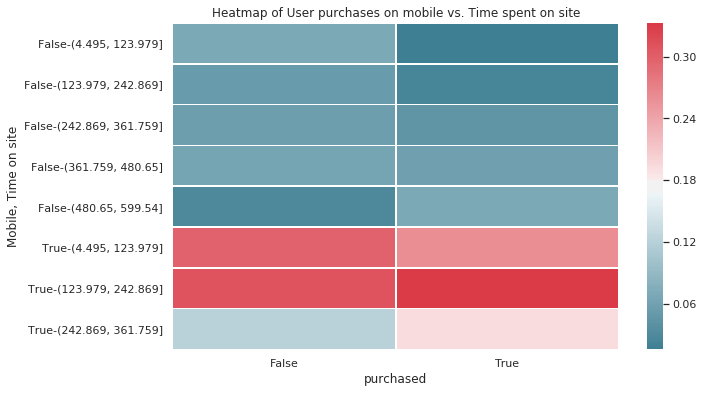

In [19]:
fig, axs = plt.subplots(figsize=(10, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(ct, cmap=cmap,
                linewidths=.5, ax=axs)
plt.title('Heatmap of User purchases on mobile vs. Time spent on site')
plt.ylabel('Mobile, Time on site')
plt.show();

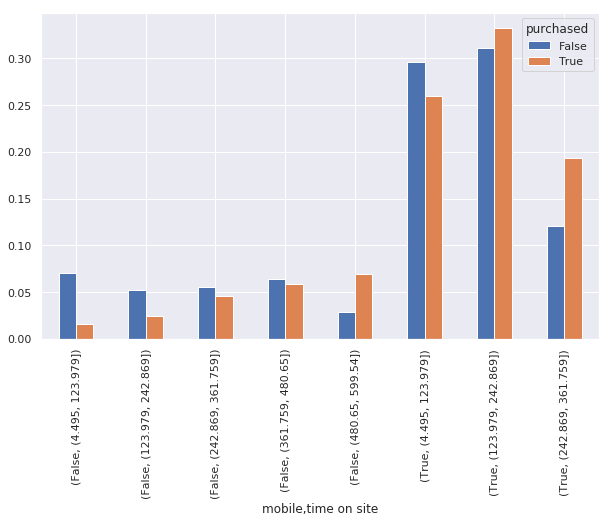

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
ct.plot(kind='bar', ax=ax);

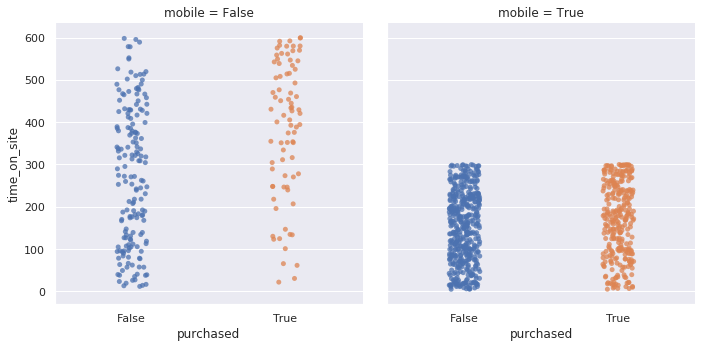

In [21]:
sns.catplot(x='purchased', y='time_on_site', 
            col='mobile', data = user_data,
            alpha=0.75);

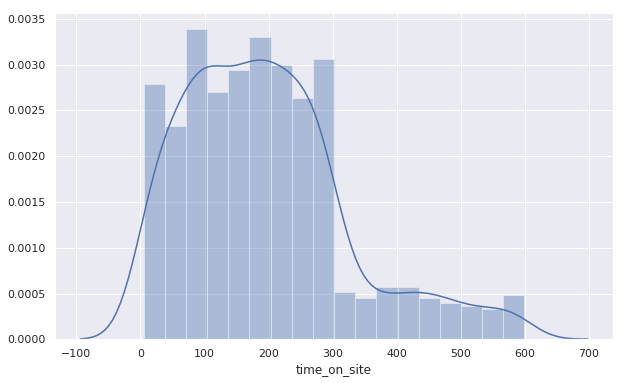

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
sns.distplot(user_data['time_on_site'], ax=ax);

In [23]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt

,purchased
time_on_site,
"(4.495, 123.979]",0.309309
"(123.979, 242.869]",0.368421
"(242.869, 361.759]",0.445000
"(361.759, 480.65]",0.354839
"(480.65, 599.54]",0.590909


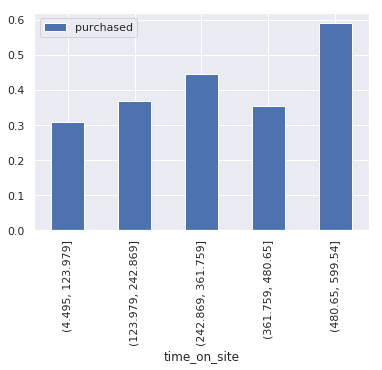

In [24]:
pt.plot.bar()

In [31]:
ct = pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins],
            rownames=['mobile'],
            colnames=['purchased', 'time on site'],
            normalize='index'
            )
ct

purchased               False       ...                   True 
time on site (4.495, 123.979]       ...        (480.65, 599.54]
mobile                              ...                        
False                   0.176       ...                   0.104
True                    0.248       ...                   0.000

[2 rows x 10 columns]

In [33]:
a = [0.248, 0.260, 	0.101333, 0.129333, 	0.165333, 	0.096]
sum(a)

0.999999

In [26]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
            rownames=['time on site'],
            colnames=['purchased', 'mobile'],
            normalize='columns'
            )
ct

purchased              False             True           
mobile                 False     True    False     True 
time on site                                            
(4.495, 123.979]    0.258824  0.407002  0.0750  0.331058
(123.979, 242.869]  0.194118  0.426696  0.1125  0.423208
(242.869, 361.759]  0.205882  0.166302  0.2125  0.245734
(361.759, 480.65]   0.235294  0.000000  0.2750  0.000000
(480.65, 599.54]    0.105882  0.000000  0.3250  0.000000

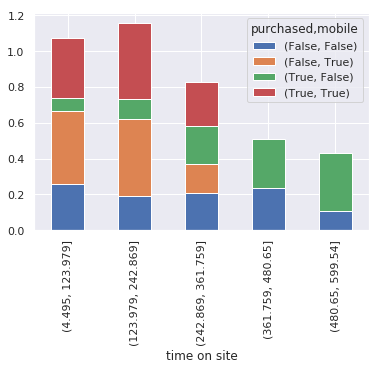

In [27]:
ct.plot(kind='bar', stacked=True)

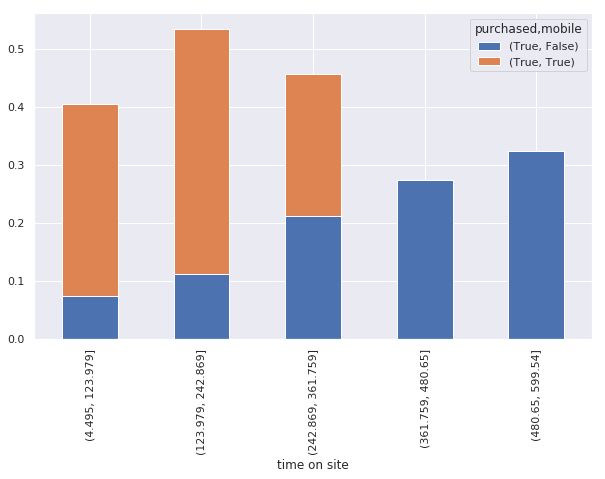

In [28]:
ct.iloc[:, [2, 3]].plot.bar(stacked=True, figsize=(10, 6));

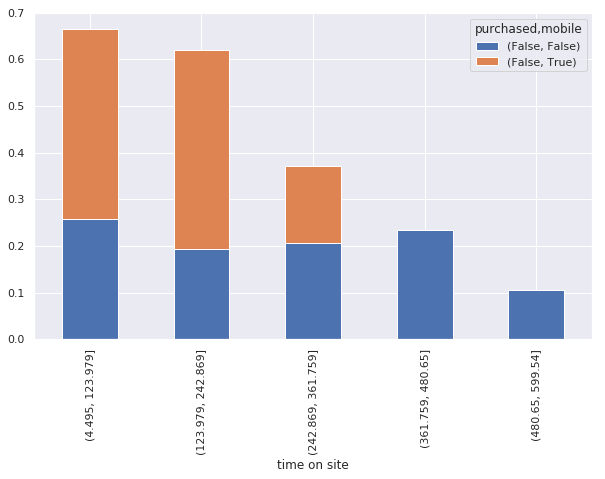

In [29]:
ct.iloc[:, [0, 1]].plot.bar(stacked=True, figsize=(10, 6));

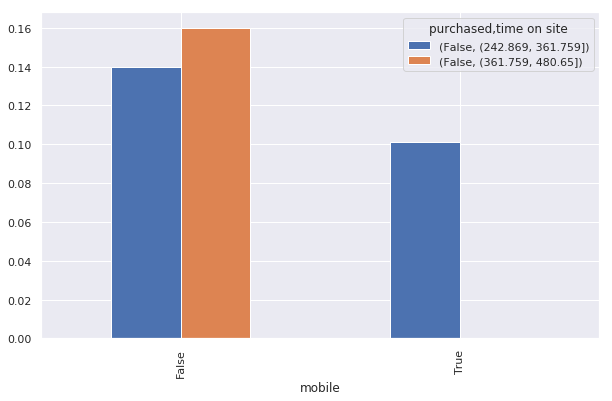

In [35]:
ct.iloc[:, [2, 3]].plot.bar(figsize=(10, 6));

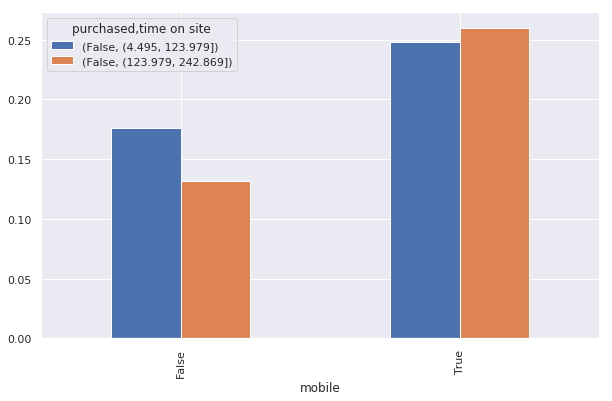

In [34]:
ct.iloc[:, [0, 1]].plot.bar(figsize=(10, 6));

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


In [38]:
file_url = 'https://raw.githubusercontent.com/hurshd0/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv' 
df = pd.read_csv(file_url, usecols = ['age', 'weight', 'exercise_time'])
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
age              1200 non-null int64
weight           1200 non-null int64
exercise_time    1200 non-null int64
dtypes: int64(3)
memory usage: 28.2 KB


In [43]:
df.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


### 1.  What are the variable types in the data?

`age (in years)` - is quantitative, discrete type   
`weight (lbs)` - is also quantitative, discrete type  
`exercise_time (in minutes/week)` - is also quantitative, discrete type  

### 2.  What are the relationships between the variables?


Depending on experiment deisgn, we can describe multiple hypothesis here,


#### 1. Hypothesis: 'People that exercise more tend to weight less'.

Which makes:  

|Relationship    |   Variable     |
| ------------------- | --------------------- | 
|Independent variable (X) | `exercise_time` |   
| Dependent variable (Y) | `weight` | 
| Confounding variable | `age`  |


#### 2. Hypothesis: Older people tend to exercise less

Which makes: 

|Relationship    |   Variable     |
| ------------------- | --------------------- | 
|Independent variable (X) | `age` |   
| Dependent variable (Y) | `exercise_time` | 
| Confounding variable | `weight`  |


### 3.  Which relationships are "real", and which spurious?

If we look at three way relationship diagram below, and choose **Hypothesis 1** than, `exercise_time` and `weight` are "real", while `age` is spurious. So, `age` has hidden effect on our experiment's outcome.

![](https://github.com/hurshd0/DS-Unit-1-Sprint-1-Dealing-With-Data/raw/master/module3-databackedassertions/three_way_relation.png)

Similarly, choosing **Hypothesis 2** would have `weight` as hidden effect that affects our experiment's outcome. 

### Exploratory Data Visualization

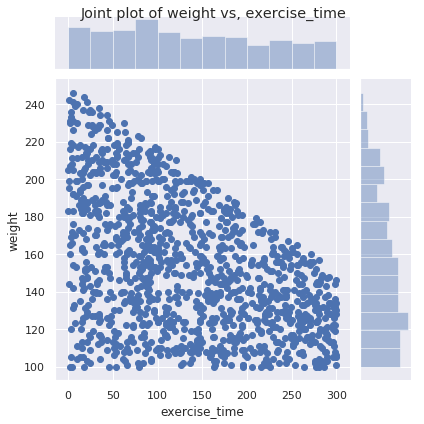

In [82]:
col_name1 = 'weight'
col_name2 = 'exercise_time'
sns.jointplot(x=col_name2,y=col_name1,data=df)
plt.suptitle(f'Joint plot of {col_name1} vs, {col_name2}');

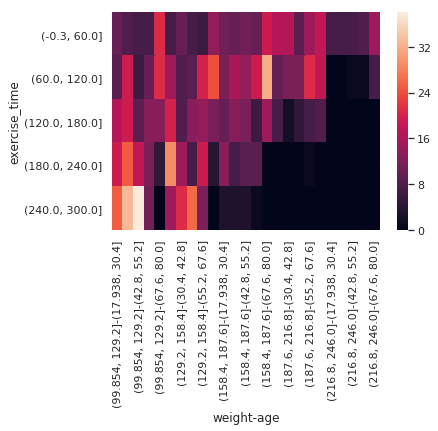

In [93]:
sns.Facetgrid(df, hue="age", col="")

Ages are uniformly distributed

Let's start with cross tab,

In [101]:
exercise_time_bins = pd.cut(df['exercise_time'], 5)
weight_bins = pd.cut(df['weight'], 5)
age_bins = pd.cut(df['age'], 5)
ex_wt_ct = pd.crosstab(exercise_time_bins, weight_bins)
ex_wt_ct

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
exercise_time,,,,,
"(-0.3, 60.0]",53,44,61,76,44
"(60.0, 120.0]",65,76,93,73,9
"(120.0, 180.0]",71,67,56,29,0
"(180.0, 240.0]",79,74,38,1,0
"(240.0, 300.0]",107,74,10,0,0


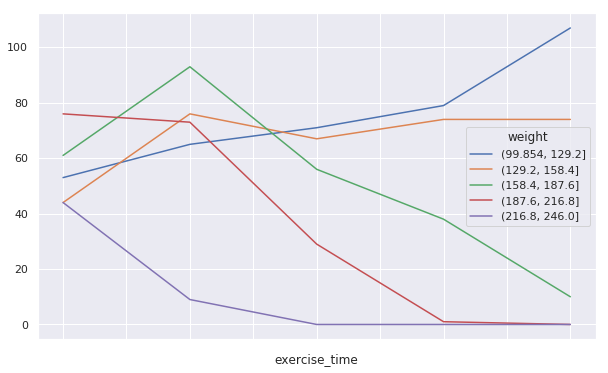

In [102]:
fig, ax = plt.subplots(figsize = (10,6))
ex_wt_ct.plot(ax=ax)

In [104]:
ex_age_ct = pd.crosstab(exercise_time_bins, age_bins)
ex_age_ct

age,"(17.938, 30.4]","(30.4, 42.8]","(42.8, 55.2]","(55.2, 67.6]","(67.6, 80.0]"
exercise_time,,,,,
"(-0.3, 60.0]",52,52,41,46,87
"(60.0, 120.0]",46,55,42,71,102
"(120.0, 180.0]",54,42,39,40,48
"(180.0, 240.0]",61,47,34,41,9
"(240.0, 300.0]",43,57,67,24,0


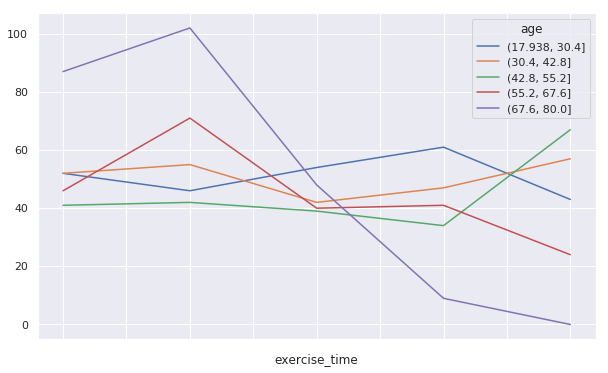

In [103]:
ex_age_ct = pd.crosstab(exercise_time_bins, age_bins)
fig, ax = plt.subplots(figsize = (10,6))
ex_age_ct.plot(ax=ax)

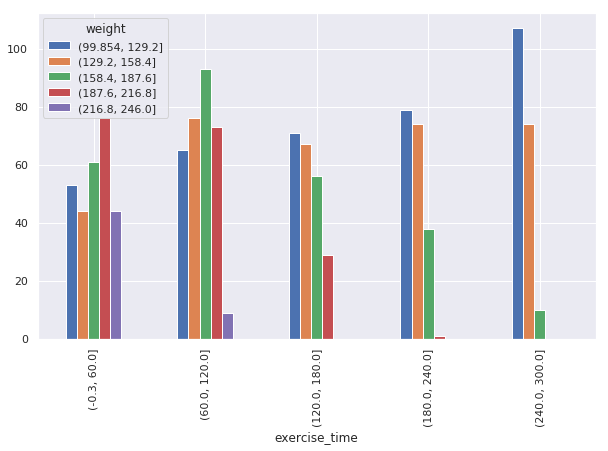

In [90]:
fig, ax = plt.subplots(figsize = (10,6))
ct.plot.bar(ax=ax);

In [92]:
exercise_time_bins = pd.cut(df['exercise_time'], 5)
weight_bins = pd.cut(df['weight'], 5)
age_bins = pd.cut(df['age'], 5)
ct = pd.crosstab(exercise_time_bins, [weight_bins, age_bins])
ct

weight         (99.854, 129.2]      ...       (216.8, 246.0]
age             (17.938, 30.4]      ...         (67.6, 80.0]
exercise_time                       ...                     
(-0.3, 60.0]                10      ...                   15
(60.0, 120.0]                9      ...                    7
(120.0, 180.0]              17      ...                    0
(180.0, 240.0]              19      ...                    0
(240.0, 300.0]              25      ...                    0

[5 rows x 25 columns]

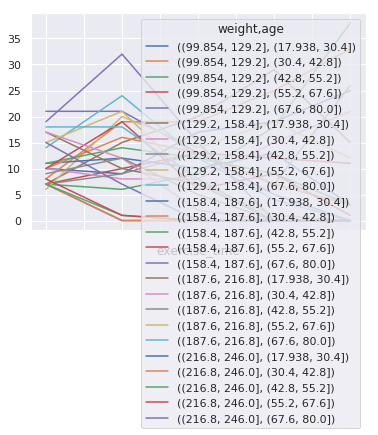

In [95]:
ct.plot()

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)